In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df=pd.read_csv('/content/wines_SPA.csv')

In [4]:
print(df.describe())

            rating   num_reviews        price         body      acidity
count  7500.000000   7500.000000  7500.000000  6331.000000  6331.000000
mean      4.254933    451.109067    60.095822     4.158427     2.946612
std       0.118029    723.001856   150.356676     0.583352     0.248202
min       4.200000     25.000000     4.990000     2.000000     1.000000
25%       4.200000    389.000000    18.900000     4.000000     3.000000
50%       4.200000    404.000000    28.530000     4.000000     3.000000
75%       4.200000    415.000000    51.350000     5.000000     3.000000
max       4.900000  32624.000000  3119.080000     5.000000     3.000000


In [5]:
df.dtypes

,0
winery,object
wine,object
year,object
rating,float64
num_reviews,int64
country,object
region,object
price,float64
type,object
body,float64


In [6]:

for col in ["winery","wine","rating","year","type","region","body", "acidity"]:
    print(f"🔍 Unique values in {col}:")
    print(df[col].unique(), "\n")

🔍 Unique values in winery:
['Teso La Monja' 'Artadi' 'Vega Sicilia' 'Pago de Carraovejas'
 'Toro Albala' 'Bodegas El Nido' 'Valdespino' 'Dominio de Pingus'
 'Alvaro Palacios' 'Ordonez' 'Bodegas Valduero' 'Vina Sastre'
 'Sierra Cantabria' 'Descendientes de J. Palacios' 'La Rioja Alta'
 'Marques de Murrieta' 'Vinedos de Paganos' 'Emilio Moro'
 'Quinta de la Quietud' 'Bodegas Mauro' 'Bodega Contador (Benjamin Romeo)'
 'Remirez de Ganuza' 'Bodegas San Roman' 'Pago de Los Capellanes'
 'Bodega Numanthia' 'Alto Moncayo' 'Mas Doix' 'Finca Moncloa'
 'Bodegas Roda' 'Martinet' 'Recaredo' 'Clos Erasmus' 'Barbadillo'
 'Gonzalez-Byass' 'Bodegas Amaren' 'Alvear' 'Equipo Navazos' 'Morca'
 'Territorio Luthier' 'Rafael Palacios' 'Terra Remota'
 'Dehesa de Los Canonigos' 'Miguel Merino' 'Gutierrez de la Vega' 'Alion'
 'Aalto' 'Carmelo Rodero' 'Dominio del Bendito' "Mas d'en Gil"
 'Casa Castillo' 'Matarromera' 'Nin-Ortiz' 'Vinas del Vero'
 'Marques de Riscal' 'Arzuaga' 'Bodegas Mas Alta' 'Dominio de Calog

In [7]:
missing_values = df.isnull().sum()
print("Columns with missing values:\n", missing_values)
df.shape

Columns with missing values:
 winery            0
wine              0
year              2
rating            0
num_reviews       0
country           0
region            0
price             0
type            545
body           1169
acidity        1169
dtype: int64


(7500, 11)

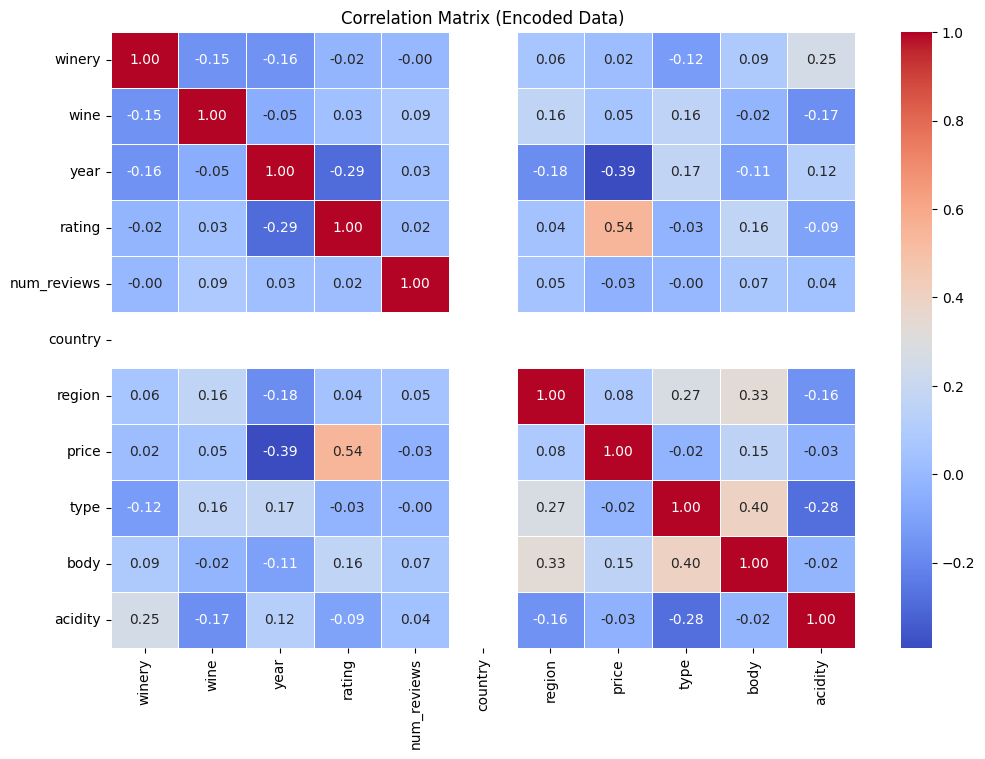

In [8]:
df_encoded = df.copy()
from sklearn.preprocessing import LabelEncoder

# Identify categorical columns
categorical_cols = df_encoded.select_dtypes(include=['object']).columns

# Encode categorical variables
encoder = LabelEncoder()
for col in categorical_cols:
    df_encoded[col] = df_encoded[col].astype(str)  # Ensure all values are strings
    df_encoded[col] = encoder.fit_transform(df_encoded[col])

# Compute correlation matrix on encoded data
corr_matrix = df_encoded.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix (Encoded Data)")
plt.show()

In [9]:
df["type"] = df["type"].fillna(df.groupby("region")["type"].transform(lambda x: x.mode()[0] if not x.mode().empty else "Red"))

In [10]:
df["body"] = df["body"].fillna(df.groupby("type")["body"].transform("median"))
df["acidity"] = df["acidity"].fillna(df.groupby("type")["acidity"].transform("median"))

In [11]:
df["type"] = df["type"].fillna(df.groupby("region")["type"].transform(lambda x: x.mode()[0] if not x.mode().empty else "Red"))

In [12]:
df = df.dropna(subset=["year"])

In [13]:
def year_value_counts(df):
    """
    Returns the value counts of the 'year' column in descending order.
    Handles missing values and converts to string for better readability.
    """
    return df["year"].fillna("Missing").astype(str).value_counts()

# Example usage:
print(year_value_counts(df))

year
2011    1190
2016     897
2015     860
2018     850
2017     731
        ... 
1928       1
1949       1
1922       1
1978       1
1925       1
Name: count, Length: 71, dtype: int64


In [14]:
df["is_non_vintage"] = df["year"].apply(lambda x: 1 if x == "N.V." else 0)
df["year"] = df["year"].replace("N.V.", None).astype(float)  # Convert year to numeric

# Check if it worked
print(df[["year", "is_non_vintage"]].head())
print("\nMissing values in 'year':", df["year"].isnull().sum())

     year  is_non_vintage
0  2013.0               0
1  2018.0               0
2  2009.0               0
3  1999.0               0
4  1996.0               0

Missing values in 'year': 288


In [15]:
df.shape

(7498, 12)

In [16]:
df = df.drop_duplicates()

# Check if duplicates were removed
print(f"Remaining rows after dropping duplicates: {df.shape[0]}")

Remaining rows after dropping duplicates: 2022


In [17]:
def detect_outliers_iqr(df, columns):
    outliers = {}
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers[col] = df[(df[col] < lower_bound) | (df[col] > upper_bound)].shape[0]

    return outliers

# Numeric columns to check for outliers
numeric_cols = ["year", "rating", "num_reviews", "price", "body", "acidity"]
outlier_counts = detect_outliers_iqr(df, numeric_cols)

print("Outlier counts per column:", outlier_counts)

Outlier counts per column: {'year': 165, 'rating': 2, 'num_reviews': 239, 'price': 243, 'body': 40, 'acidity': 110}


In [18]:
Q1 = df["year"].quantile(0.25)
Q3 = df["year"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df = df[(df["year"] >= lower_bound) & (df["year"] <= upper_bound)]


In [19]:
from scipy.stats.mstats import winsorize

winsorize_cols = ["num_reviews", "price", "acidity"]

for col in winsorize_cols:
    df[col] = winsorize(df[col], limits=[0.05, 0.05])

In [20]:
df["price"] = np.log1p(df["price"])

In [21]:
outlier_counts = detect_outliers_iqr(df, ["year", "rating", "num_reviews", "price", "body", "acidity"])
print("Outliers after handling:", outlier_counts)

Outliers after handling: {'year': 39, 'rating': 2, 'num_reviews': 217, 'price': 0, 'body': 40, 'acidity': 0}


/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:4968: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:4968: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:4968: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:4968: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:4968: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:4968: UserWarning: Warning: 'partition' will ignore the 'mask'

In [22]:
df["num_reviews"] = winsorize(df["num_reviews"], limits=[0.1, 0.1])  # Cap top & bottom 10%

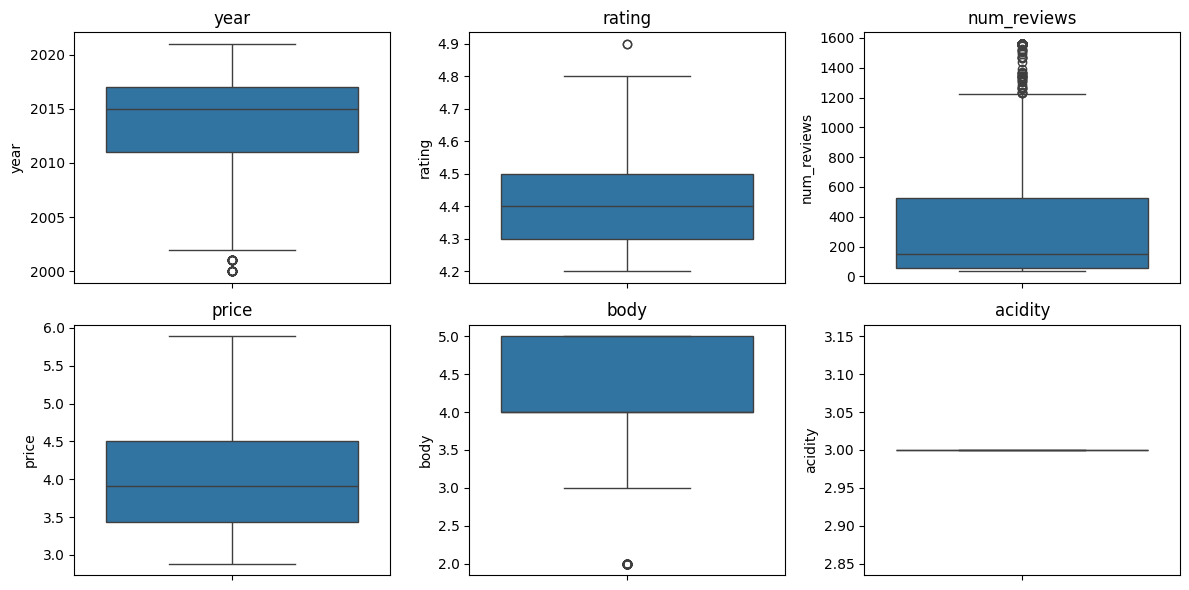

In [23]:
numeric_cols = ["year", "rating", "num_reviews", "price", "body", "acidity"]

plt.figure(figsize=(12, 6))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(y=df[col])
    plt.title(col)
plt.tight_layout()
plt.show()

In [24]:
import numpy as np

# Function to detect outliers using IQR
def count_outliers_iqr(df, cols):
    outlier_counts = {}
    for col in cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        outlier_counts[col] = len(outliers)
    return outlier_counts

# Numeric columns
numeric_cols = ["year", "rating", "num_reviews", "price", "body", "acidity"]

# Count outliers
outlier_counts = count_outliers_iqr(df, numeric_cols)

# Display results
for col, count in outlier_counts.items():
    print(f"{col}: {count} outliers")


year: 39 outliers
rating: 2 outliers
num_reviews: 217 outliers
price: 0 outliers
body: 40 outliers
acidity: 0 outliers


/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:4968: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:4968: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:4968: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:4968: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:4968: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:4968: UserWarning: Warning: 'partition' will ignore the 'mask'

In [25]:
df["num_reviews"] = winsorize(df["num_reviews"], limits=[0.15, 0.15])  # Cap top & bottom 15%

In [26]:
upper_limit = df["num_reviews"].quantile(0.99)  # 99th percentile
lower_limit = df["num_reviews"].quantile(0.01)  # 1st percentile

df = df[(df["num_reviews"] >= lower_limit) & (df["num_reviews"] <= upper_limit)]

/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:4968: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:4968: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


In [27]:
outlier_counts = count_outliers_iqr(df, numeric_cols)
print("Outliers after final handling:", outlier_counts)

Outliers after final handling: {'year': 39, 'rating': 2, 'num_reviews': 0, 'price': 0, 'body': 40, 'acidity': 0}


/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:4968: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:4968: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:4968: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:4968: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:4968: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:4968: UserWarning: Warning: 'partition' will ignore the 'mask'

In [28]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Select numeric columns
numeric_cols = ["year", "rating", "num_reviews", "price", "body", "acidity"]

# Standardization (Mean = 0, Std = 1)
scaler_standard = StandardScaler()
df_standardized = df.copy()
df_standardized[numeric_cols] = scaler_standard.fit_transform(df[numeric_cols])

# Normalization (Scales between 0 and 1)
scaler_minmax = MinMaxScaler()
df_normalized = df.copy()
df_normalized[numeric_cols] = scaler_minmax.fit_transform(df[numeric_cols])

<ipython-input-29-2523303b6fda>:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[row, col_idx].set_xticklabels(["Standardized", "Normalized"])
<ipython-input-29-2523303b6fda>:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[row, col_idx].set_xticklabels(["Standardized", "Normalized"])
<ipython-input-29-2523303b6fda>:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[row, col_idx].set_xticklabels(["Standardized", "Normalized"])
<ipython-input-29-2523303b6fda>:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[row, col_idx].set_xticklabels(["Standardized", "Normalized"])
<ipython-input-29-2523303b6fda>:13: UserWarning: set_ticklabels() sh

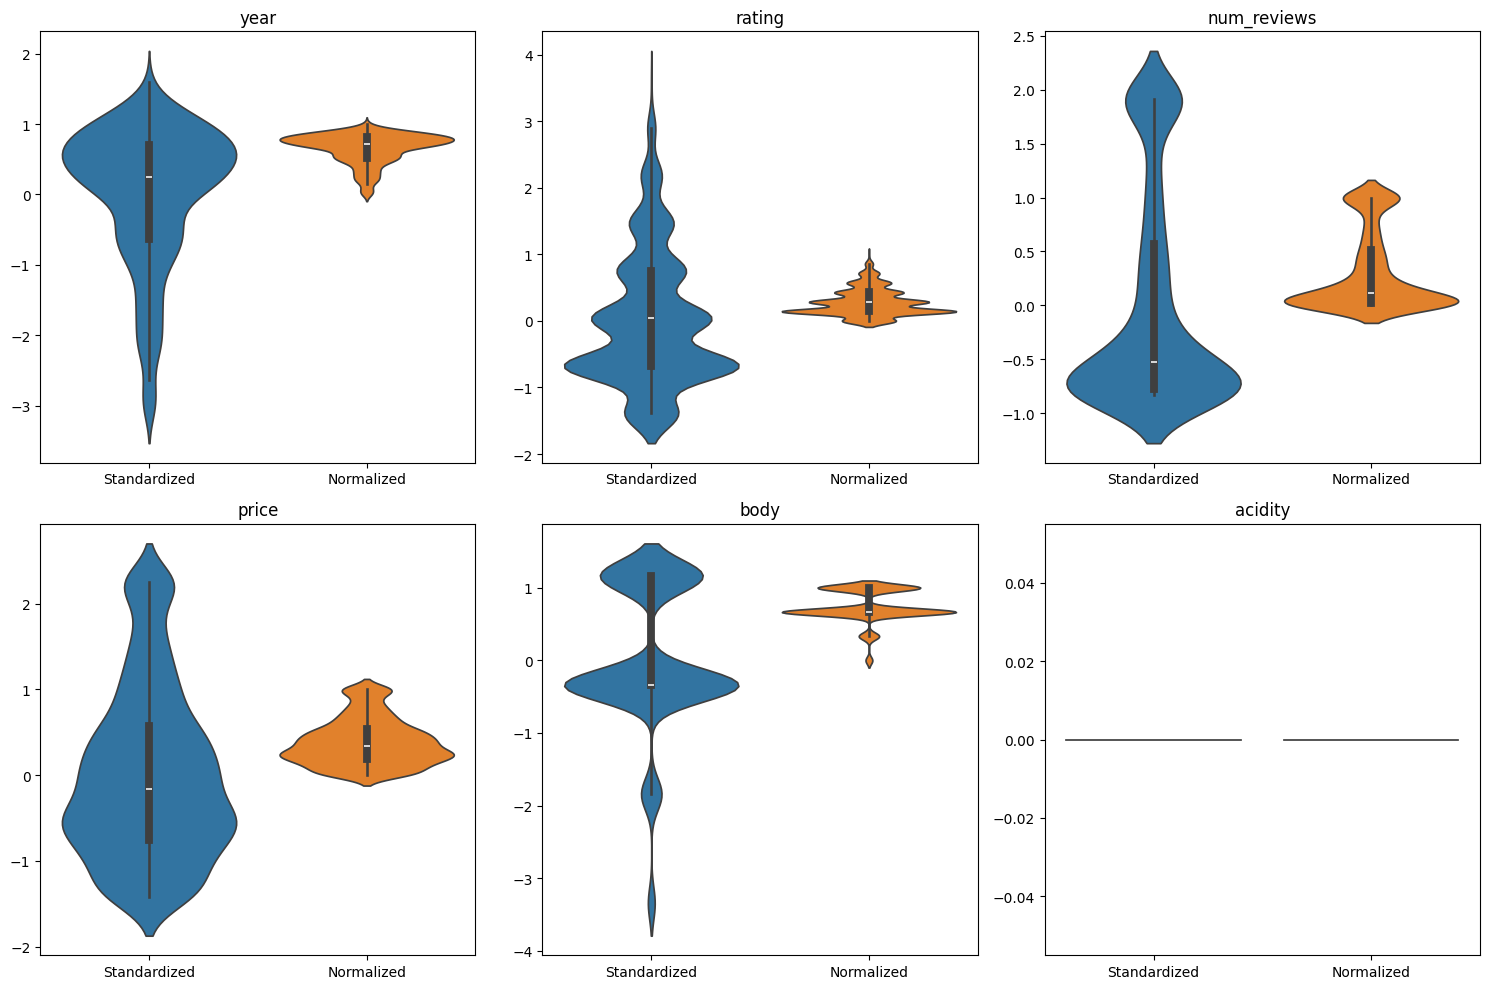

In [29]:
df_comparison = pd.DataFrame()

for col in numeric_cols:
    df_comparison[f"{col}_Standardized"] = df_standardized[col]
    df_comparison[f"{col}_Normalized"] = df_normalized[col]

# Plot violin plots for each numeric column
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

for i, col in enumerate(numeric_cols):
    row, col_idx = divmod(i, 3)
    sns.violinplot(data=df_comparison[[f"{col}_Standardized", f"{col}_Normalized"]], ax=axes[row, col_idx])
    axes[row, col_idx].set_xticklabels(["Standardized", "Normalized"])
    axes[row, col_idx].set_title(col)

plt.tight_layout()
plt.show()

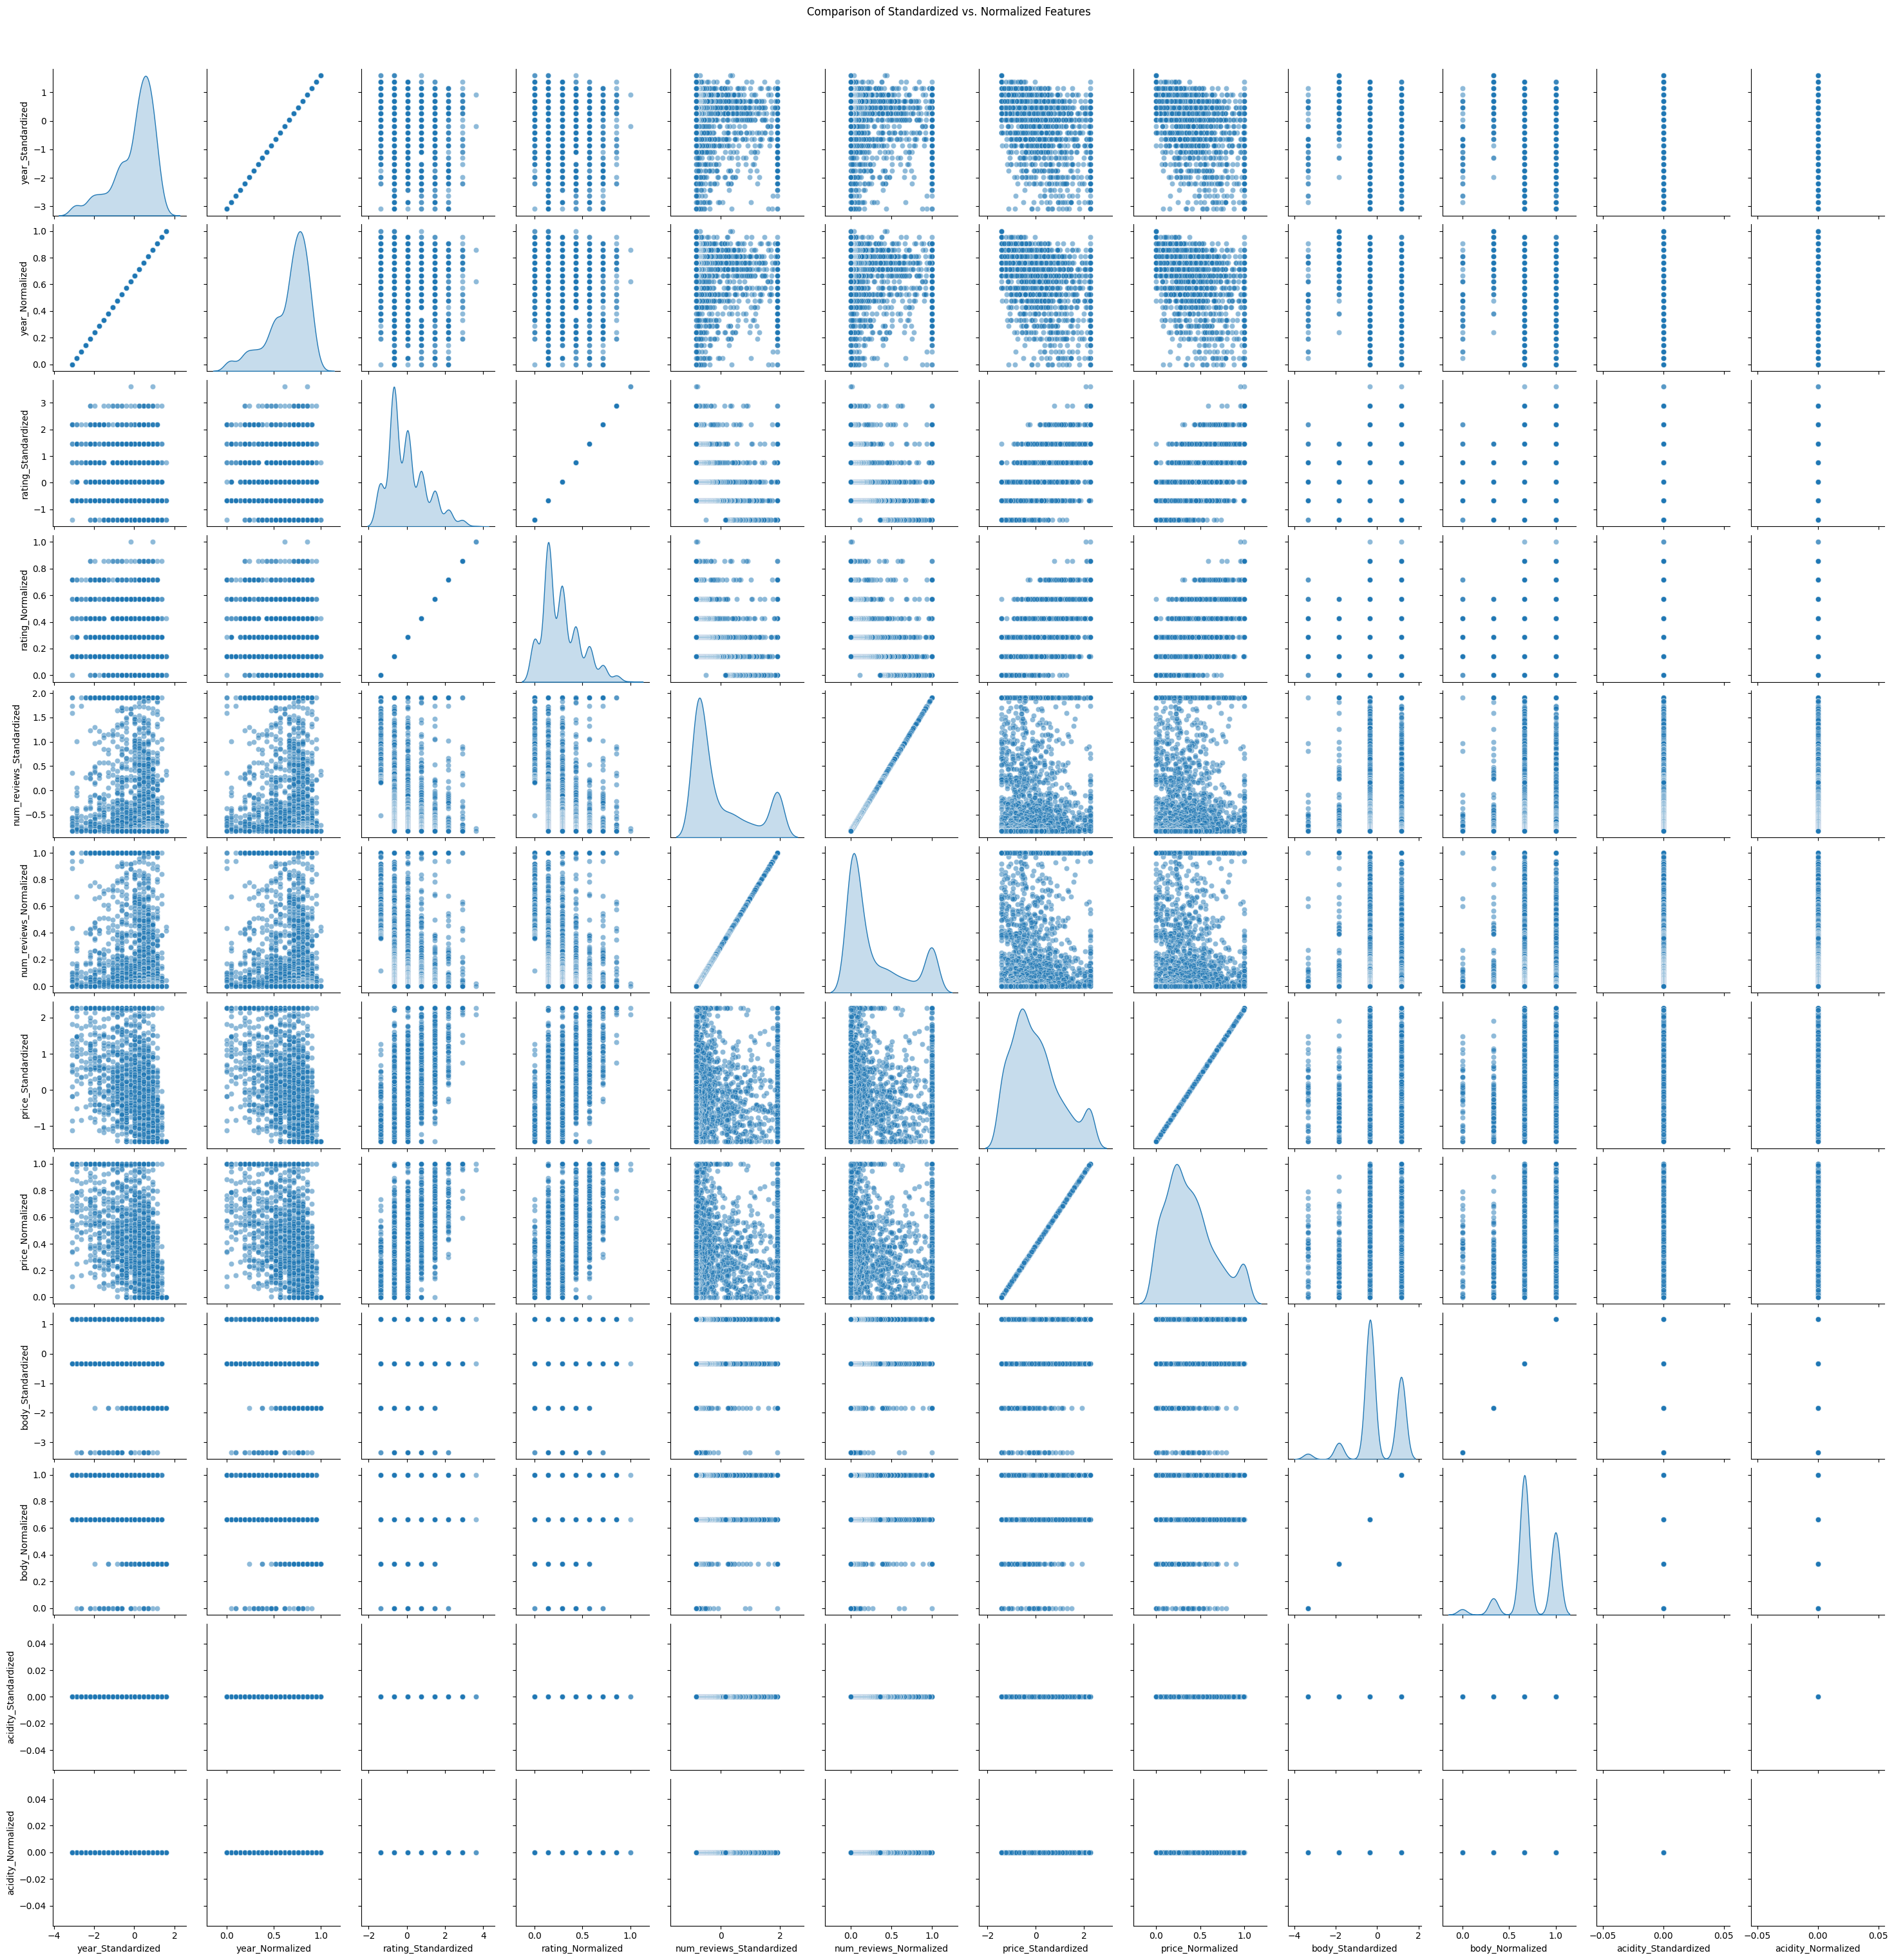

In [30]:
df_comparison = pd.DataFrame()

for col in numeric_cols:
    df_comparison[f"{col}_Standardized"] = df_standardized[col]
    df_comparison[f"{col}_Normalized"] = df_normalized[col]

# Melt the data for better visualization
df_melted = df_comparison.melt(var_name="Feature", value_name="Value")

# Create scatterplots with histograms
g = sns.pairplot(df_comparison, diag_kind="kde", markers="o", plot_kws={"alpha": 0.5})
g.fig.suptitle("Comparison of Standardized vs. Normalized Features", y=1.02)

plt.show()

In [31]:
from scipy.stats import skew, kurtosis

# Function to compute statistical metrics
def compare_scaling(df_standardized, df_normalized, numeric_cols):
    metrics = pd.DataFrame(columns=["Mean_Standardized", "Std_Standardized", "Skew_Standardized", "Kurtosis_Standardized",
                                    "Mean_Normalized", "Std_Normalized", "Skew_Normalized", "Kurtosis_Normalized"])

    for col in numeric_cols:
        metrics.loc[col] = [
            df_standardized[col].mean(), df_standardized[col].std(), skew(df_standardized[col]), kurtosis(df_standardized[col]),
            df_normalized[col].mean(), df_normalized[col].std(), skew(df_normalized[col]), kurtosis(df_normalized[col])
        ]

    return metrics

# Call function
scaling_metrics = compare_scaling(df_standardized, df_normalized, numeric_cols)

# Display comparison table
print(scaling_metrics)

             Mean_Standardized  Std_Standardized  Skew_Standardized  \
year              8.528102e-15           1.00028          -1.136494   
rating           -3.814995e-16           1.00028           0.832333   
num_reviews       6.358324e-17           1.00028           1.013805   
price            -3.179162e-16           1.00028           0.667625   
body              2.463851e-16           1.00028          -0.746398   
acidity           0.000000e+00           0.00000                NaN   

             Kurtosis_Standardized  Mean_Normalized  Std_Normalized  \
year                      0.748714         0.659795        0.213788   
rating                    0.235474         0.277964        0.200092   
num_reviews              -0.549896         0.303057        0.364587   
price                    -0.305930         0.387303        0.271844   
body                      1.189986         0.741984        0.222011   
acidity                        NaN         0.000000        0.000000   

    

In [32]:
scaler_std = StandardScaler()
scaler_minmax = MinMaxScaler()

df_scaled = df.copy()

# Apply standardization where needed
df_scaled[["year", "rating", "num_reviews", "price"]] = scaler_std.fit_transform(df[["year", "rating", "num_reviews", "price"]])

# Apply normalization where needed
df_scaled[["body"]] = scaler_minmax.fit_transform(df[["body"]])

In [33]:
df_scaled.to_csv('df_scaled.csv', index=False)